inspiration:
- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

read this: 
- https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1
- https://www.kaggle.com/dansbecker/handling-missing-values
- https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

1. Тщательный анализ данных.
- Исследовать данные на наличие пропусков и некорректных значений. Либо удалить их, либо сделать imputing (проинтерполировать).
- Посмотреть на распределение целевой переменной. Идентифицировать аномалии. Решить, что делать: убрать выбросы из датасета или преобразовать целевую переменную (например, посредством преобразования Бокса-Кокса). 
- Проанализировать признаки. Отобрать те, которые лично вам кажутся наиболее важными. Посмотреть на их распределение (в том числе на попарные). 
- Посмотреть на совместное распределение целевой переменной и выбранных признаков. 
- Сформулировать гипотезы о том, какие сочетания признаков могут быть полезны. Добавить их (если придумаете). Подсказка: отрисуйте выборку на карте, посчитайте расстояние до важных объектов в этом городе, посчитайте статистики по районам и по ближайшим объектам (не забудьте, что эти статистики нужно считать по обучающей выборке!).

In [9]:
!conda install pytz -y

Solving environment: done

## Package Plan ##

  environment location: /home/qazybek/miniconda3/envs/ds

  added / updated specs:
    - pytz


The following NEW packages will be INSTALLED:

  pytz               pkgs/main/noarch::pytz-2021.1-pyhd3eb1b0_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv', index_col='Id')
# X_test = pd.read_csv('test.csv', index_col='Id')

# y_test = pd.read_csv('sample_submission.csv', index_col='Id')

In [3]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [60]:
corr = train.corr()
mask = np.zeros((len(corr), len(corr)))

for i in range(len(corr)):
    for j in range(len(corr)):
        if i > j:
            mask[i, j] = 1        
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.]])

<AxesSubplot:>

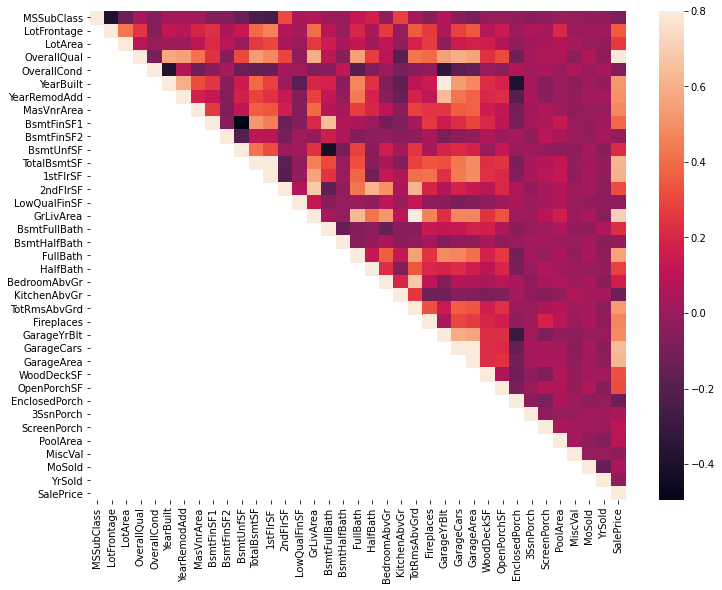

In [61]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=0.8, mask=mask)

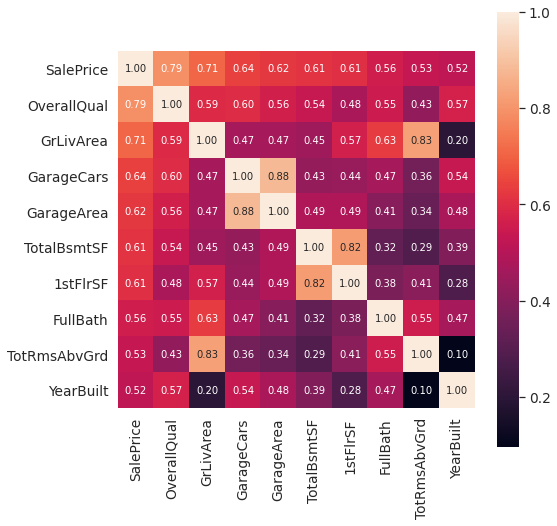

In [65]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize=(8, 8))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [9]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

We can observe some 

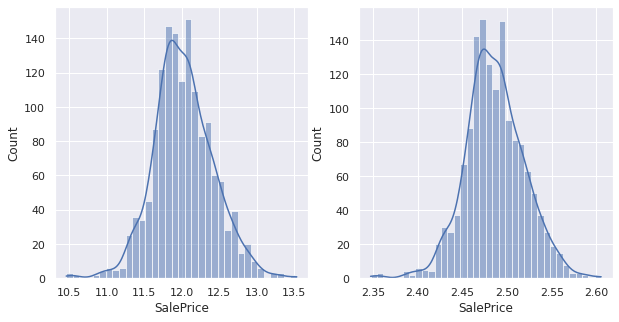

In [74]:
# combination of histogram and kdeplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(train['SalePrice'], ax=ax1, kde=True);
sns.histplot(np.log(train['SalePrice']), ax=ax2, kde=True);

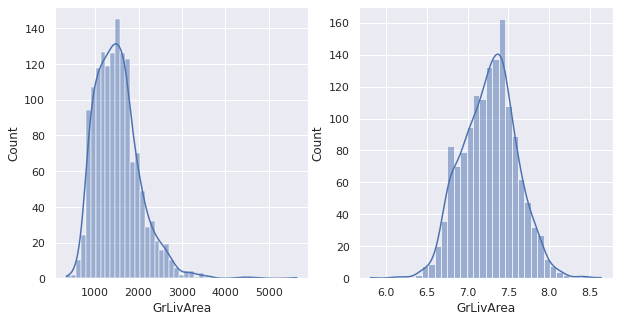

In [73]:
# combination of histogram and kdeplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(train['GrLivArea'], ax=ax1, kde=True);
sns.histplot(np.log(train['GrLivArea']), ax=ax2, kde=True);

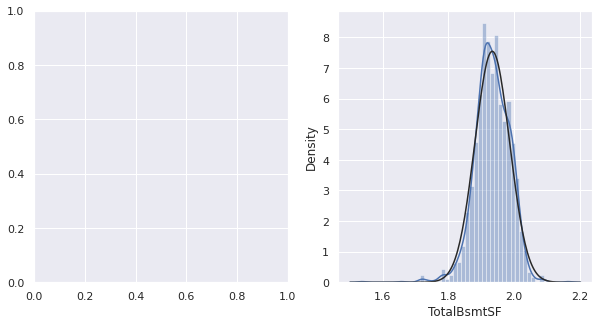

In [81]:
# combination of histogram and kdeplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# handle zeros
train['HasBsmt'] = pd.Series(len(train['TotalBsmtSF']), index=train.index)
train['HasBsmt'] = 0 
train.loc[train['TotalBsmtSF']>0,'HasBsmt'] = 1

# train.loc[train['HasBsmt']==1,'TotalBsmtSF'] = np.log(train['TotalBsmtSF'])

# sns.distplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);

# sns.histplot(train['TotalBsmtSF'], ax=ax1, kde=True);
# sns.histplot(np.log(train['TotalBsmtSF']), ax=ax2, kde=True);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


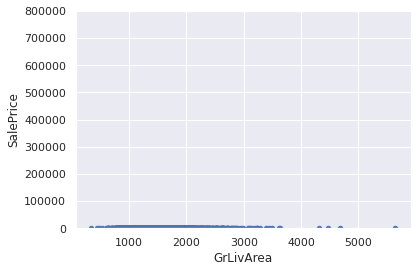

In [69]:
feature = 'GrLivArea'

data = pd.concat([train['SalePrice'], train[feature]], axis=1)
data.plot.scatter(x=feature, y='SalePrice', ylim=(0, 800000));

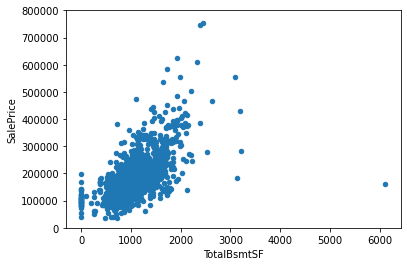

In [27]:
feature = 'TotalBsmtSF'

data = pd.concat([train['SalePrice'], train[feature]], axis=1)
data.plot.scatter(x=feature, y='SalePrice', ylim=(0, 800000));

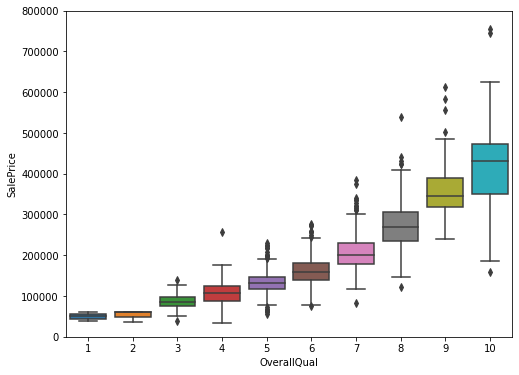

In [29]:
feature = 'OverallQual'

data = pd.concat([train['SalePrice'], train[feature]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=feature, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

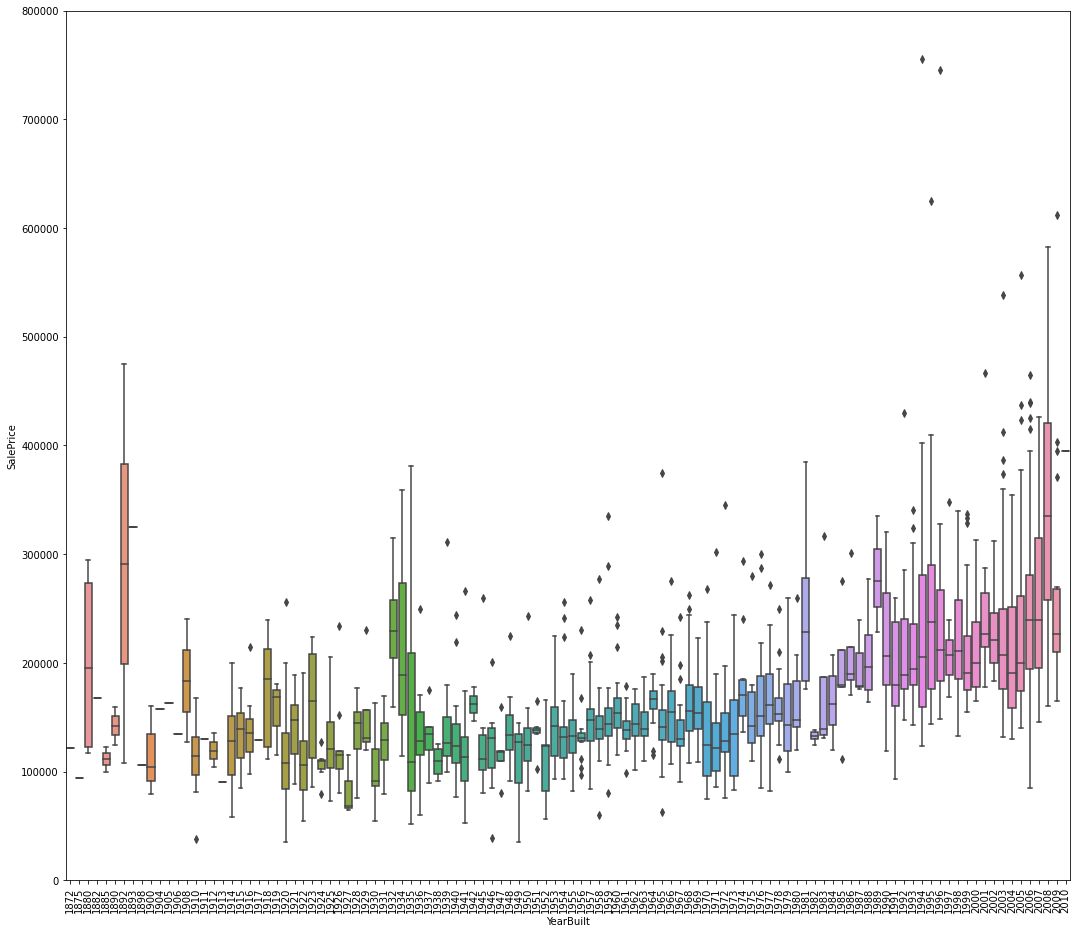

In [32]:
feature = 'YearBuilt'

data = pd.concat([train['SalePrice'], train[feature]], axis=1)
f, ax = plt.subplots(figsize=(18, 16))
fig = sns.boxplot(x=feature, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

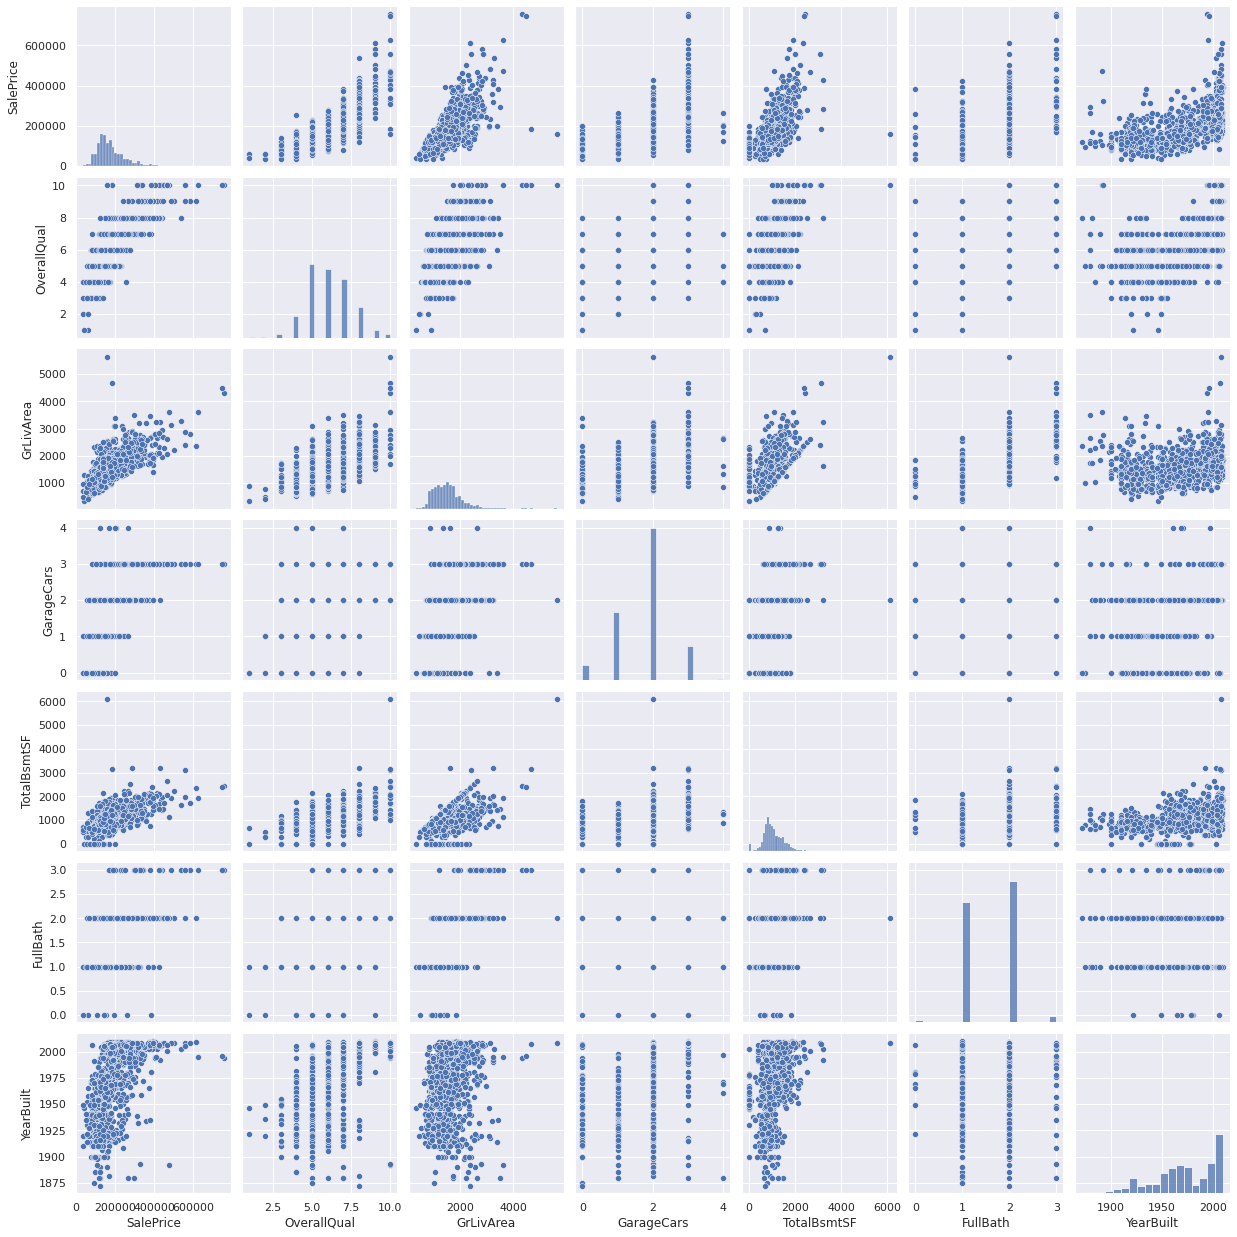

In [67]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

## Storing Results

In [68]:
train['SalePrice'] = np.log(train['SalePrice'])